# Major Project: Dataset of images of living things with Coarse and Fine dataset
Name: Marco Stephanus Tianadi

**SID: 46775226**

Kaggle username: Marco Stephanus

# Introduction
This notebook is for the Major Project submission for COMP7220/8220, on the living things images dataset. It contains the following section:


*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!unzip -q /gdrive/MyDrive/Comp8220/living-thing-classification-coarse.zip    # CHANGE DIRECTORY


In [ ]:
!unzip -q /gdrive/MyDrive/Comp8220/living-thing-classification-fine-private.zip 
!unzip -q /gdrive/MyDrive/Comp8220/living-thing-classification-coarse-private.zip  

In [3]:
!ls -alh 

total 2.4M
drwxr-xr-x 1 root root 4.0K Jun  3 11:23 .
drwxr-xr-x 1 root root 4.0K Jun  3 11:21 ..
drwxr-xr-x 4 root root 4.0K Jun  1 22:50 .config
drwxr-xr-x 5 root root 4.0K Jun  3 11:23 public
drwxr-xr-x 1 root root 4.0K Jun  1 22:51 sample_data
-rw-r--r-- 1 root root 2.3M Mar 11 09:04 sample_test_with_label_coarse_0.csv


In [4]:
# Import necessary libraries to be use for the data set
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
batch_size = 64
img_size = 112
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('/content/public')


In [6]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y


In [ ]:
fine_names, coarse_names = load_target_names()
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [ ]:
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


# Conventional ML Model : Selected Coarse Data

RandomForest Classifier model 1

The best performing prediction for the kaggle submission in the public test (31%) is using SVM with rbf kernel. However, after doing a lot of testing, I found in Coarse dataset using  RandomForest Classifier with ***n_estimators=500, random_state=42*** produced higher result compared to other model, which is 47%

# Notes on Conventional Ml Model

Below are the process before selecting the best model for this part.

* In this major project, the tasks and the dataset have been provided in iLearn for COMP8220/7220 Machine learning. The task is to predict the category label of the living things with the dataset of images of living things. It have 2 dataset, which are Coarse and Fine dataset

* In Conventional ML model the goal is to find which model have the statistical score for classification task in 2 datasets. 

* Since this is an image Classification problem with a lot of classification , Logistic Regression is not an option. Therefore several model have been used to get the best results and here are the model:
   * Decision Tree Classifier
   * Random Forest Classifier
   * K-Nearest Neighbors (KNN)
   * Support Vector Machine (linear, rbf, and polynomial)
   * Principal Component Analysis 

* First I tried using Decision Tree Classifier, the result shows 32%. I tried another model, which is RandomForest Classifier. With RandomForest, I experiment with 4 models. The first model I use **n_estimators=100, random_state=42** and the result is 46%, which is higher compared to the Decision Tree result. After that I tried to experiment with different settings. Increaseing the **n_estimator to 500**, add max_leaf_nodes, and gridsearch.

* In the next model I use 2 KNN models with different setting, but the result is lower compared to the previous model. KNN model 1 with n_neighbors=3 is 23% and the second model is slightly higher with n_neighbors=5 is 23.9%.

* For the next Model I tried to experiment with Support Vector Machine with different kernel (linear, rbf and polynomial) to see which kernel gives the best performance. In this Coarse dataset, rbf kernel gives a better performance,46%

* Next Dimensionality reduction or PCA have been implemented to the model, I implement PCA into the 2 models that well perfomed, which are randomforest and SVM with rbf kernel. The result performance for random forest with 46%, which is about the same without PCA  and SVM with 45%, which is lower than the original SVM.


For the Fine dataset, because it have 50 classification, the result is significantly lower compare to the coarse dataset. First I choose the model that gives the best perfomance with coarse data, Random forest classifier. In this model it gives me 0.0708. It is not the result that I expected, hence I tried with another model.

Second is KNN, this model give the worse result of all the model it's 0.0334.

I tried with SVM with rbf kernel. The result is improving which is 0.063. After that I tried to implement PCA to SVM to improve the model, 0.0602. The result with PCA is worse without PCA. Thefore I decided that for fine data, randomforest classifier is well-perfomed model.


In [ ]:
fine_grained = False

In [ ]:
X,Y = create_dataset_sklearn('train', fine_grained=False)

In [ ]:
X_train, y_train = create_dataset_sklearn('train', fine_grained=False)
X_test, y_test = create_dataset_sklearn('test', fine_grained=False)
X_val, y_val = create_dataset_sklearn('val', fine_grained=False)

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# DecisionTree Classifier
tree_clf = DecisionTreeClassifier()

# Fit training data
tree_clf.fit(X_train, y_train)

# Validation data predictiion
decisiontree_pred = tree_clf.predict(X_val)

# Evaluate the DecisionTrees classifier's accuracy on the validation data
tree_clf_accuracy = accuracy_score(y_val, decisiontree_pred)

print("DecisionTrees Validation Accuracy:", tree_clf_accuracy)

DecisionTrees Validation Accuracy: 0.32


In [ ]:
N = 50000     # num elements in test.csv
Decisiontree_pred = np.tile(y_pred, (N//len(y_pred) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = Decisiontree_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-conv-decision.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Randomforest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest Classifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the training data
rnd_clf.fit(X_train, y_train)

#Random Forest prediction
randomforest_pred = rnd_clf.predict(X_val)

# Evaluate the RandomForest classifier's accuracy on the validation data
rnd_clf_accuracy = accuracy_score(y_val, randomforest_pred)

print("Randomforest Validation Accuracy:", rnd_clf_accuracy)


Randomforest Validation Accuracy: 0.4694


In [ ]:
#Random Forest Classifier
rnd_clf_1 = RandomForestClassifier(n_estimators=500, random_state=42)

# Fit the training data
rnd_clf_1.fit(X_train, y_train)

#Random Forest prediction
randomforest_pred_1 = rnd_clf_1.predict(X_val)

# Evaluate the RandomForest classifier's accuracy on the validation data
rnd_clf_1_accuracy = accuracy_score(y_val, randomforest_pred_1)

print("Randomforest_1 Validation Accuracy:", rnd_clf_1_accuracy)

Randomforest_1 Validation Accuracy: 0.4778


In [ ]:
#Random Forest Classifier
rnd_clf_2 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)

# Fit the training data
rnd_clf_2.fit(X_train, y_train)

#Random Forest prediction
randomforest_pred_2 = rnd_clf_2.predict(X_val)

# Evaluate the RandomForest classifier's accuracy on the validation data
rnd_clf_2_accuracy = accuracy_score(y_val, randomforest_pred_2)

print("Randomforest_2 Validation Accuracy with max leaf:", rnd_clf_2_accuracy)

Randomforest_2 Validation Accuracy with max leaf: 0.4412


In [ ]:
# Using GridSearch CV for randomforest
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_leaf_nodes":[8,16,32,]
    
}
rnd_clf_3=RandomForestClassifier(random_state=42)
rnd_grid_search = GridSearchCV(estimator=rnd_clf_3,param_grid=parameters, cv=5)
rnd_grid_search.fit(X_train, y_train)

best_rf_clf = rnd_grid_search.best_estimator_
#Random Forest prediction
randomforest_pred_3 = best_rf_clf.predict(X_val)

# Evaluate the RandomForest classifier's accuracy on the validation data
rnd_clf_3_accuracy = accuracy_score(y_val, randomforest_pred_3)

print("Randomforest_2 Validation Accuracy with gridsearch:", rnd_clf_3_accuracy)

Randomforest_2 Validation Accuracy with gridsearch: 0.4506


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#KNN classifier
KNN_1 = KNeighborsClassifier(n_neighbors=3)

#Fit the training data
KNN_1.fit(X_train, y_train)

#KNN prediction on validation data 
KNN_pred_1 = KNN_1.predict(X_val)

#KNN accuracy on validation data
KNN_1_accuracy = accuracy_score(y_val, KNN_pred_1)
print("KNN vaidation Accuracy:", KNN_1_accuracy)

KNN vaidation Accuracy: 0.234


In [ ]:
#KNN classifier
KNN_1 = KNeighborsClassifier(n_neighbors=5)

#Fit the training data
KNN_1.fit(X_train, y_train)

#KNN prediction on validation data 
KNN_pred_1 = KNN_1.predict(X_val)

#KNN accuracy on validation data
KNN_1_accuracy = accuracy_score(y_val, KNN_pred_1)
print("KNN vaidation Accuracy:", KNN_1_accuracy)

KNN vaidation Accuracy: 0.2392


## SVM

### SVM using Linear Kernel

In [ ]:
# SVM Classifier model
svm_clf_1 = LinearSVC(C=1.0)
#Fit the training data
svm_clf_1.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
#SVM prediction on validation data 
svm_clf_1_pred = svm_clf_1.predict(X_val)

#SVM accuracy on validation data
svm_clf_1_accuracy = accuracy_score(y_val, svm_clf_1_pred)
print("SVM_1 validation Accuracy:", svm_clf_1_accuracy)

SVM_1 validation Accuracy: 0.2784


### SVM using rbf kernel

In [ ]:
# SVM Classifier model with rbf kernel
svm_clf_2 = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
#Fit the training data
svm_clf_2.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
#SVM prediction on validation data 
svm_clf_2_pred = svm_clf_2.predict(X_val)

#SVM accuracy on validation data
svm_clf_2_accuracy = accuracy_score(y_val, svm_clf_2_pred)
print("SVM_2 validation Accuracy:", svm_clf_2_accuracy)

SVM_2 validation Accuracy: 0.4632


In [ ]:
N = 50000     # num elements in test.csv
svm_clf_2_pred = np.tile(svm_clf_2_pred, (N//len(svm_clf_2_pred) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = svm_clf_2_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-conv-svm_rbf.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

### SVM using Polynomial kernel

In [ ]:
# SVM Classifier model with polynomial kernel

poly_kernel_svm_clf_1 = Pipeline([
("scaler", StandardScaler()),
("svm_clf", SVC(kernel="poly",  C=5, degree=3, coef0=1))
])
#Fit the training data
poly_kernel_svm_clf_1.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [ ]:
#SVM prediction on validation data 
poly_kernel_svm_clf_1_pred = poly_kernel_svm_clf_1.predict(X_val)

#SVM accuracy on validation data
poly_kernel_svm_clf_1_accuracy = accuracy_score(y_val, poly_kernel_svm_clf_1_pred)
print("SVM_3 validation Accuracy:", poly_kernel_svm_clf_1_accuracy)

SVM_3 validation Accuracy: 0.3666


## Dimensionality Reduction (PCA) with randomforest

In [ ]:
# PCA model
pca = PCA(n_components=10)  #number of components to 
reduced_features = pca.fit_transform(X_train)  # Apply PCA on the training data
reduced_val_features = pca.transform(X_val)  # Apply PCA on the validation data

In [ ]:
#Train the Random Forest Classifier with PCA
rnd_clf_pca = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf_pca.fit(reduced_features, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
# Predict and Evaluate RandomForest with PCA
randomforest_pred_pca = rnd_clf_pca.predict(reduced_val_features)
rnd_clf_pca_accuracy = accuracy_score(y_val, randomforest_pred_pca)
print("Random Forest_pca Validation Accuracy:", rnd_clf_pca_accuracy)

Random Forest_pca Validation Accuracy: 0.46


## Dimensionality Reduction (PCA) with SVM

In [ ]:
# PCA model
pca = PCA(n_components=10)  #number of components to retain
reduced_features = pca.fit_transform(X_train)  # Apply PCA on the training data
reduced_val_features = pca.transform(X_val)  # Apply PCA on the validation data
reduced_val_features.shape

(5000, 10)

In [ ]:
#Train SVM with rbf with PCA
svm_clf_PCA = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_clf_PCA.fit(reduced_features, y_train)

SVC(probability=True)

In [ ]:
# Predict and Evaluate SVM with PCA
svm_clf_PCA_pred = svm_clf_PCA.predict(reduced_val_features)

In [ ]:
svm_clf_PCA_accuracy = accuracy_score(y_val, svm_clf_PCA_pred)
print("SVM validation Accuracy with PCA:", svm_clf_PCA_accuracy)

SVM validation Accuracy with PCA: 0.4534


# Machine Learing : Selected Fine data

The best model selected for Fine datq is Random Forest Classifier with 0.0708 score.

In [ ]:
fine_grained = True

In [ ]:
X_train, y_train = create_dataset_sklearn('train', fine_grained=True)
X_test, y_test = create_dataset_sklearn('test', fine_grained=True)
X_val, y_val = create_dataset_sklearn('val', fine_grained=True)

## RandomForest Classifier : Fine Data
using n_estimators = 500

In [ ]:
# RandomForest Classifier
rnd_clf_fine_1 = RandomForestClassifier(n_estimators=500, random_state=42)
#Fit training data
rnd_clf_fine_1.fit(X_train, y_train)

# Predict RandomForest validation data
randomforest_fine_pred_1 = rnd_clf_fine_1.predict(X_val)

# Evaluate the Random Forest classifier's accuracy on the validation data
rnd_clf_fine_1_accuracy = accuracy_score(y_val, randomforest_fine_pred_1)

print("Randomforest_fine_1 Validation Accuracy:", rnd_clf_fine_1_accuracy)

Randomforest_fine_1 Validation Accuracy: 0.0708


In [ ]:
N = 50000
rfc1_fine = np.tile(randomforest_fine_pred_1, (N//len(randomforest_fine_pred_1) + 1))[:N]
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = rfc1_fine
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-conv_randomforest_fine_data.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = prediction
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-conv_randomforest_fine_data.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## KNN Classifier : Fine Data

In [ ]:
#KNN classifier
KNN_fine_1 = KNeighborsClassifier(n_neighbors=5)

#Fit the training data
KNN_fine_1.fit(X_train, y_train)

# Predict KNN validation data 
KNN_fine_pred_1 = KNN_fine_1.predict(X_val)

# Evaluate the KNN accuracy on the validation data
KNN_fine_1_accuracy = accuracy_score(y_val, KNN_fine_pred_1)
print("KNN vaidation Accuracy:", KNN_fine_1_accuracy)

KNN vaidation Accuracy: 0.0334


## SVM using RBF

In [ ]:
# SVM Classifier with rbf kernel
svm_clf_fine_1 = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)

#Fit the training data
svm_clf_fine_1.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
# Predict SVM validation data 
svm_clf_fine_1_pred = svm_clf_fine_1.predict(X_val)

# Evaluate the SVM accuracy on the validation data
svm_clf_fine_1_accuracy = accuracy_score(y_val, svm_clf_fine_1_pred)
print("SVM_fine_1 validation Accuracy:", svm_clf_fine_1_accuracy)

SVM_fine_1 validation Accuracy: 0.063


# SVM using RBF and PCA

In [ ]:
pca = PCA(n_components=10)  #Number of components to retain
reduced_features = pca.fit_transform(X_train)  # Apply PCA on the training data
reduced_val_features = pca.transform(X_val)  # Apply PCA on the validation data
reduced_val_features.shape

(5000, 10)

In [ ]:
#Train SVM with rbf with PCA
svm_clf_fine_PCA = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_clf_fine_PCA.fit(reduced_features, y_train)

SVC(probability=True)

In [ ]:
# Predict and Evaluate SVM with PCA
svm_clf_fine_PCA_pred = svm_clf_fine_PCA.predict(reduced_val_features)

In [ ]:
svm_clf_fine_PCA_accuracy = accuracy_score(y_val, svm_clf_fine_PCA_pred)
print("SVM fine data validation Accuracy with PCA:", svm_clf_fine_PCA_accuracy)

SVM fine data validation Accuracy with PCA: 0.0602


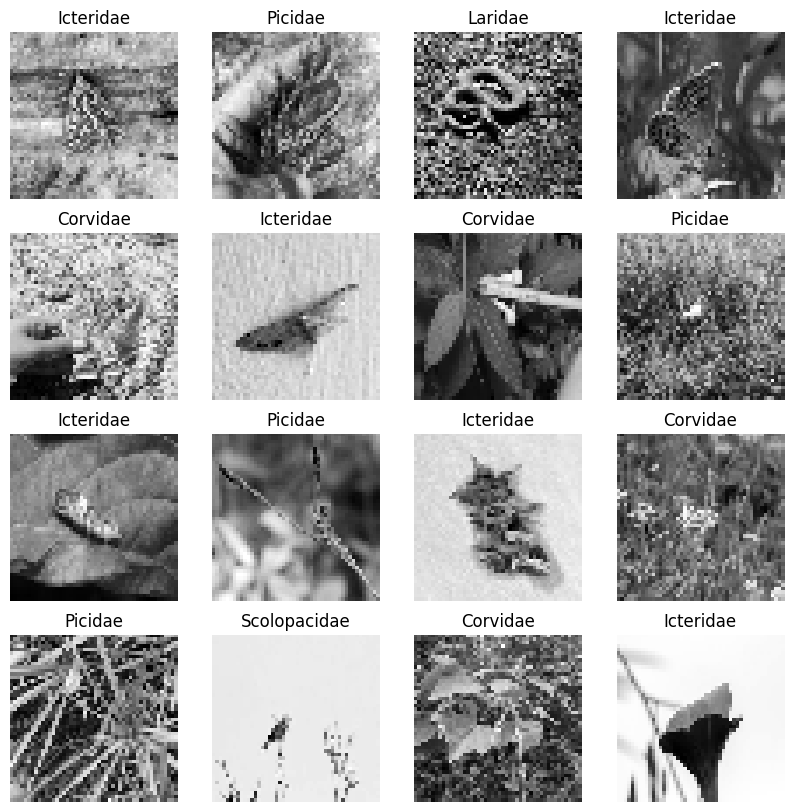

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X[i].reshape(48,48), cmap='gray')
  if fine_grain:
    plt.title(fine_names[Y[i]])
  else:
    plt.title(coarse_names[Y[i]])
  plt.axis("off")
plt.show();

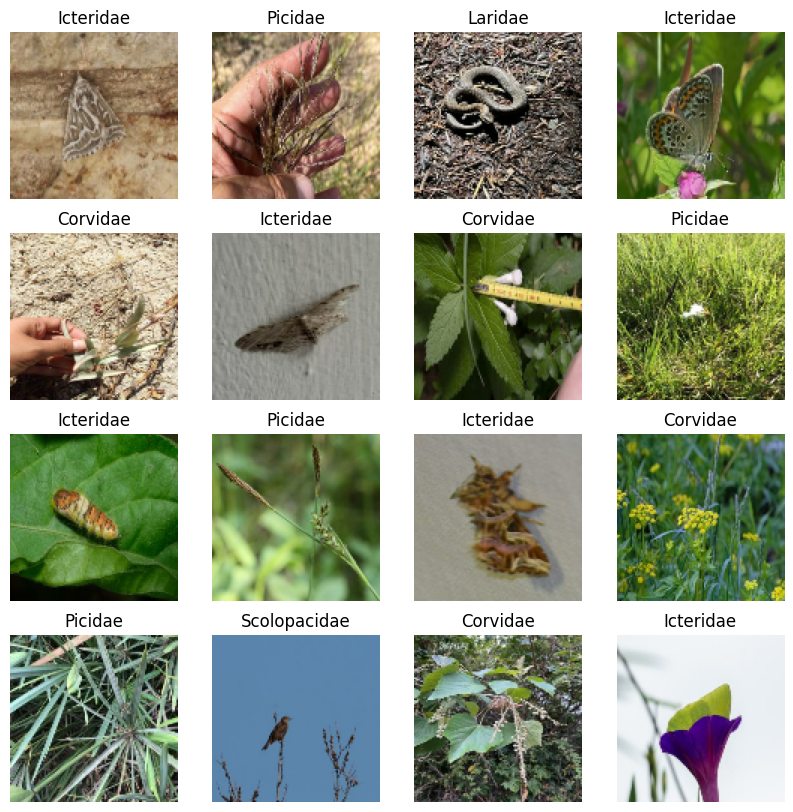

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

# 2. Deep Learning : Coarse Data


# Deep Learning model: Selected Coarse Data

The final model that produced the best-performing predictions for the Kaggle submission (72%) was using MobilenetV2.

but after doing fine tuning the result got better, which is 78%

# Notes on Deep Learning Model
Below are the process before selecting the best model for this part.

* To find the best Deep Learning model that well perfomed, I started by build a simple model.

* The first and simple network is Convolutional Neural Network (CNN), **model 1** that consist of 2 convolutional layers, two max pooling layers, and two fully connected layers. The architecture used for this model are:
  * The first layer is a Conv2D layer with 32 filters. It uses a kernel size of (3,3), which means it will slide a 3x3 window over the input image. The activation function used is 'relu'
  * MaxPooling2D: it performs a downsampling operation by taking the maximum value within each 2x2 window
  * Conv2D layer with 64 filters and a kernel size of (3,3). It also uses the 'relu' activation function.
  * MaxPooling2D
  * Flatten layer is added
  * Dense layer with 128 neurons and 'relu' activation function is added
  * Last is, the output layer consists of a Dense layer with 8 neurons and 'softmax' activation function. The 'softmax' function normalizes the output values, producing a probability distribution over the 8 possible classes in the classification problem.

After that I compile the CNN using 'adam' optimizer, use 'SparseCategorialCrossentropy as long function and fit it with 8 epoch. After training the CNN, I got 0.5676 for validation accuracy and training accuracy is 0.9224. This simple model gives a poor perfomance because the validation accuracy is decreasing with each epoch where it starts at 0.6116 and decrease until 0.5676.

In **Model 2**, I'm adding more:
   * Convolutional Layers, These layers have increasing filter sizes of 64, 128, 256, and 512.
   * MaxPooling2D: 4 more extra layers

The goal is to improve the validation accuracy, which I got 0.6534 for validation accuracy and training accuracy is 0.7500. I have 8 epoch in **Model 2** and it perform better compared to **Model 1** because for each epoch the validation accuracy is increasing. 


In **Model 3**, I put more dense layers dropout layer has been added and here are the architecture:
 * Dropout layer with a rate of 0.2
 * Dense layers : 3 additional dense layer with (128,84,32,8) neurons.

**Model 3** aim to further improve the model's performance and prevent overfitting by introducing dropout regularization. However, the result gives validation accuracy: 0.6543 and training accuracy: 0.7359. The result in model 3 is about the same in **model 2**. 

Another way to improve the performance is to apply Regularization with **L2 Regularization** and adding more droput layers. I applied those setting into **model 4**. The changes from **model 3** is to make the model perform better and here is the results, training accuracy: 0.6968  validation accuracy: 0.6722. In this model the result is slightly better compared to **model 3**. This is proven by applying regularization into the model will increase the performance.

In **model 5**, with the same architecture but the difference is that I'm using **kernel_initializer="he_normal"** and remove **L2 Regularization**. However, the effectives dropped and it gives poor perfomance, which is training accuracy: 0.3865 and validation accuracy: 0.4282.

In **model 6**, I have combine both regularization: he_normal and L2 Regularization. This combination is expected to improve the model perfomance.The result for this model gives an improvement compare to **model 5**, but still poor performance. It gives training accuracy: 0.5290 and validation accuracy: 0.5386. 


I also tried **ResNet** architecture. It's a different model but it gives a poor performance, **ResNet** result:  training accuracy: 0.8097 validation accuracy: 0.4966. 

I implement transfer learning from **MobileNetV2** to increase the model performance, and the result for validation accuracy is 0.7074, which is the best so far from the previous model. The next model, using the same network **(MobilenetV2)** with additional 1 dropout layer. The result is improving, validation accuracy: 0.7273.

Another way to improve the performance and accurracy of the **MobilenetV2 model**, is to implement Fine tuning (**fine tuning** model). The result for this model is; Training accuracy: 0.8775 and validation accuracy: 0.7818. So far this model give the best accuracy. 

In the next **fine tune model**, I tried the combination of using 'elu','selu', and 'relu', adding batch normalization, increase the dropout layer strength and experiment with the numbers of fine tune layers. From fine tune model 2 until fine tune model 5, the best result is from fine tune model 4, that have the validation accuracy of  0.7708.

In the next model I tried to train fine tune model 4 to have 15 epoch, but the validation accuracy start decreasing with after 10 epoch, hence the epoch must be stop at 10 epoch to give have the best performance.

I tried to implement data augmentation for the coarse data set using the **fine tuning** model and then result is validation accuracy: 0.7814 (78%)

For the Fine dataset, because it have 50 classification, it gives less result compared to the coarse dataset, which only have 8 classification. I tried with the basic CNN model and it gives me 0.1360, which is very low score. Therefore, I tried using another model and applied fine tuning, which is **fine data using fine tuning** model, it gives me 0.3939 (39%). This is a huge improvement from the previous model. 

For the next model,**Fine data using fine tuning V1**. I'm experimenting with fine tune the layers at 150 and 
 the result is validation accuracy: 0.3296. The result is decreasing hence I'm trying to fix it in the next model.

In the next model, **Fine data using fine tuning model 3** I experiment with different activation 'elu' and 'selu'. However, it's not perfoming well because the result is 0.2468 (24%)

Even after using augmentation the model result  give a second best result after the **fine data using fine tuning V1**, which is 0.3834















In [7]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from keras.models import Sequential
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import selu, elu

In [8]:
fine_grain = False

In [9]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=batch_size)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=batch_size)

### Model 1  
Basic CNN model

In [ ]:
# Build a simple CNN model 
CNNmodel_1 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(8, activation='softmax')
    ])

In [ ]:
CNNmodel_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
CNNmodel_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_1 = CNNmodel_1.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 244s 149ms/step - loss: 1.2117 - accuracy: 0.5743 - val_loss: 1.1094 - val_accuracy: 0.6116
Epoch 2/8
1563/1563 [==============================] - 220s 141ms/step - loss: 1.0246 - accuracy: 0.6366 - val_loss: 1.0572 - val_accuracy: 0.6329
Epoch 3/8
1563/1563 [==============================] - 233s 149ms/step - loss: 0.8771 - accuracy: 0.6856 - val_loss: 1.1211 - val_accuracy: 0.6234
Epoch 4/8
1563/1563 [==============================] - 201s 128ms/step - loss: 0.7036 - accuracy: 0.7467 - val_loss: 1.2590 - val_accuracy: 0.5973
Epoch 5/8
1563/1563 [==============================] - 221s 141ms/step - loss: 0.5305 - accuracy: 0.8102 - val_loss: 1.5001 - val_accuracy: 0.5710
Epoch 6/8
1563/1563 [==============================] - 218s 139ms/step - loss: 0.3956 - accuracy: 0.8590 - val_loss: 1.8573 - val_accuracy: 0.5572
Epoch 7/8
1563/1563 [==============================] - 170s 109ms/step - loss: 0.2988 - accuracy: 0.8944 - val_loss: 2.4837 - va

Validation acuuracy: 56%

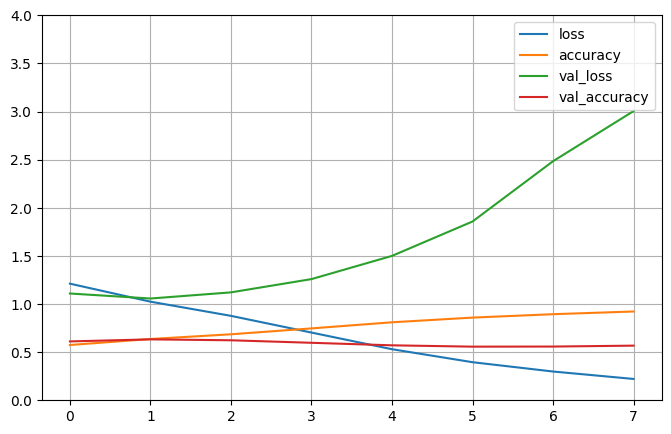

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-4]
plt.show()

## Model 2

This CNN model, it have more conv2d, maxpooling layers and filters

In [ ]:
# CNN model with more layers
CNNmodel_2 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(8, activation='softmax')
    ])

In [ ]:
CNNmodel_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 128)     

In [ ]:
CNNmodel_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_2 = CNNmodel_2.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 206s 128ms/step - loss: 1.2721 - accuracy: 0.5488 - val_loss: 1.1915 - val_accuracy: 0.5817
Epoch 2/8
1563/1563 [==============================] - 157s 101ms/step - loss: 1.0840 - accuracy: 0.6224 - val_loss: 1.0151 - val_accuracy: 0.6420
Epoch 3/8
1563/1563 [==============================] - 194s 124ms/step - loss: 0.9804 - accuracy: 0.6556 - val_loss: 0.9625 - val_accuracy: 0.6600
Epoch 4/8
1563/1563 [==============================] - 194s 124ms/step - loss: 0.9061 - accuracy: 0.6796 - val_loss: 0.9507 - val_accuracy: 0.6663
Epoch 5/8
1563/1563 [==============================] - 192s 123ms/step - loss: 0.8454 - accuracy: 0.6991 - val_loss: 0.9677 - val_accuracy: 0.6594
Epoch 6/8
1563/1563 [==============================] - 155s 99ms/step - loss: 0.7882 - accuracy: 0.7167 - val_loss: 1.0065 - val_accuracy: 0.6544
Epoch 7/8
1563/1563 [==============================] - 160s 102ms/step - loss: 0.7310 - accuracy: 0.7338 - val_loss: 1.0644 - val

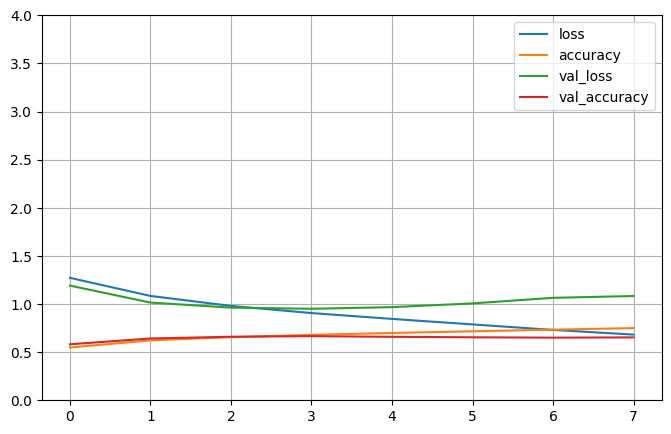

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.show()

## Model 3

In this model I'm adding 1 droputlayer and more dense layer

In [ ]:
CNNmodel_3 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2), #adding dropout layer
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='softmax')
])

In [ ]:
CNNmodel_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

In [ ]:
CNNmodel_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_3 = CNNmodel_3.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 260s 157ms/step - loss: 1.3102 - accuracy: 0.5346 - val_loss: 1.1675 - val_accuracy: 0.5968
Epoch 2/8
1563/1563 [==============================] - 231s 148ms/step - loss: 1.1134 - accuracy: 0.6167 - val_loss: 1.0475 - val_accuracy: 0.6363
Epoch 3/8
1563/1563 [==============================] - 173s 111ms/step - loss: 1.0198 - accuracy: 0.6469 - val_loss: 0.9985 - val_accuracy: 0.6520
Epoch 4/8
1563/1563 [==============================] - 212s 136ms/step - loss: 0.9522 - accuracy: 0.6679 - val_loss: 0.9750 - val_accuracy: 0.6572
Epoch 5/8
1563/1563 [==============================] - 195s 125ms/step - loss: 0.8899 - accuracy: 0.6883 - val_loss: 0.9434 - val_accuracy: 0.6709
Epoch 6/8
1563/1563 [==============================] - 155s 99ms/step - loss: 0.8390 - accuracy: 0.7038 - val_loss: 0.9539 - val_accuracy: 0.6717
Epoch 7/8
1563/1563 [==============================] - 191s 122ms/step - loss: 0.7877 - accuracy: 0.7213 - val_loss: 1.0162 - val

by adding 1 droputlayer the validation accuracy increase to 65%. But the validation loss still high, which is higher than 1.

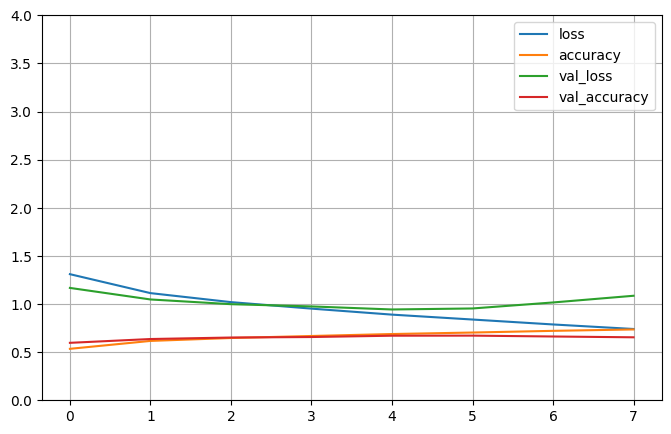

In [ ]:
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.show()

## 4. Model 4

In this model, Im adding kernel_regularizer=regularizers.l2, which to improven the model performance.

In [ ]:
CNNmodel_4 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),  #adding dropout layer 
    keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),  #adding dropout layer 2
    keras.layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),  #adding dropout layer 3
    keras.layers.Dense(8, activation='softmax')
])

In [ ]:
CNNmodel_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

In [ ]:
CNNmodel_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_4 = CNNmodel_4.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 257s 155ms/step - loss: 1.5366 - accuracy: 0.5132 - val_loss: 1.2374 - val_accuracy: 0.5854
Epoch 2/8
1563/1563 [==============================] - 243s 155ms/step - loss: 1.2182 - accuracy: 0.5974 - val_loss: 1.1515 - val_accuracy: 0.6163
Epoch 3/8
1563/1563 [==============================] - 227s 145ms/step - loss: 1.1423 - accuracy: 0.6264 - val_loss: 1.0973 - val_accuracy: 0.6359
Epoch 4/8
1563/1563 [==============================] - 169s 108ms/step - loss: 1.0940 - accuracy: 0.6442 - val_loss: 1.0767 - val_accuracy: 0.6480
Epoch 5/8
1563/1563 [==============================] - 204s 130ms/step - loss: 1.0529 - accuracy: 0.6592 - val_loss: 1.0539 - val_accuracy: 0.6541
Epoch 6/8
1563/1563 [==============================] - 201s 129ms/step - loss: 1.0139 - accuracy: 0.6743 - val_loss: 1.0315 - val_accuracy: 0.6629
Epoch 7/8
1563/1563 [==============================] - 203s 130ms/step - loss: 0.9822 - accuracy: 0.6877 - val_loss: 1.0427 - va

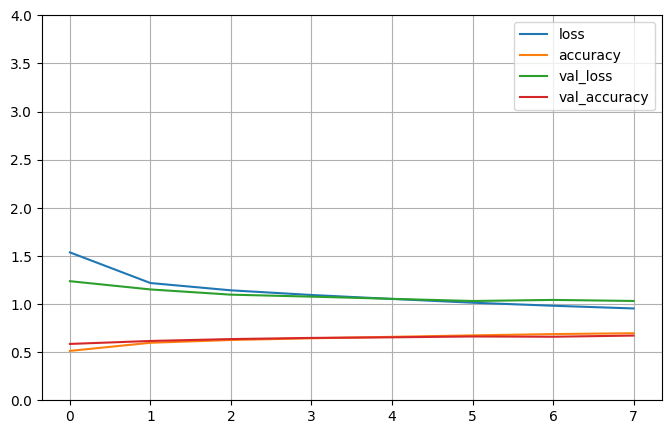

In [ ]:
pd.DataFrame(history_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.show()

Model 4 gives the best accuracy compared to other model

## Model 5

in this model I remove the regularizers and 
Using kernel_initializer="he_normal" and 
use SGD optimizer


In [ ]:
CNNmodel_5 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2), #adding dropout layer  
    keras.layers.Dense(64, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2), #adding dropout layer 2
    keras.layers.Dense(32, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),  #adding dropout layer 3
    keras.layers.Dense(8, activation='softmax')
])

In [ ]:
CNNmodel_5.summary()

In [ ]:
CNNmodel_5.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_5 = CNNmodel_5.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 222s 141ms/step - loss: 1.8210 - accuracy: 0.3403 - val_loss: 1.6201 - val_accuracy: 0.3594
Epoch 2/8
1563/1563 [==============================] - 196s 125ms/step - loss: 1.6521 - accuracy: 0.3328 - val_loss: 1.5892 - val_accuracy: 0.3594
Epoch 3/8
1563/1563 [==============================] - 194s 124ms/step - loss: 1.6221 - accuracy: 0.3394 - val_loss: 1.5801 - val_accuracy: 0.3594
Epoch 4/8
1563/1563 [==============================] - 158s 101ms/step - loss: 1.6079 - accuracy: 0.3469 - val_loss: 1.5729 - val_accuracy: 0.3594
Epoch 5/8
1563/1563 [==============================] - 192s 123ms/step - loss: 1.5953 - accuracy: 0.3531 - val_loss: 1.5645 - val_accuracy: 0.3607
Epoch 6/8
1563/1563 [==============================] - 195s 125ms/step - loss: 1.5819 - accuracy: 0.3584 - val_loss: 1.5490 - val_accuracy: 0.3710
Epoch 7/8
1563/1563 [==============================] - 209s 133ms/step - loss: 1.5658 - accuracy: 0.3640 - val_loss: 1.5304 - va

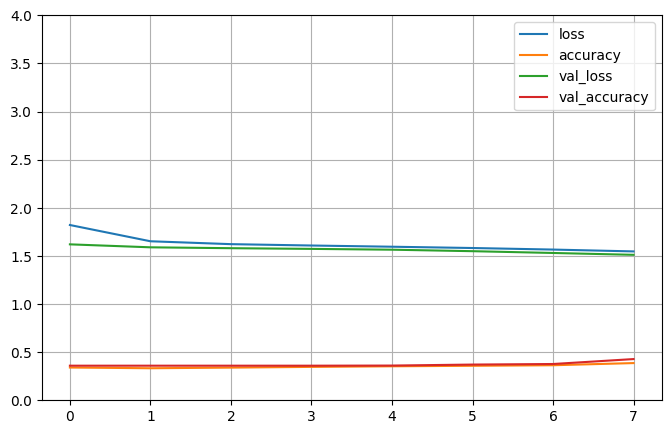

In [ ]:
pd.DataFrame(history_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.show()

## Model 6

Since the model 5 is not very good. I put back the regularizer and change the activation from **relu** to **elu**

In [ ]:
from keras import regularizers
CNNmodel_6 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='elu'),

    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='elu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2), #adding dropout layer 
    keras.layers.Dense(64, activation='elu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2), #adding dropout layer 2
    keras.layers.Dense(32, activation='elu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2), #adding dropout layer 3
    keras.layers.Dense(8, activation='softmax')
])

In [ ]:
CNNmodel_6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 26, 26, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 12, 12, 128)     

In [ ]:
CNNmodel_6.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_6 = CNNmodel_6.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 197s 125ms/step - loss: 5.8320 - accuracy: 0.4182 - val_loss: 5.5907 - val_accuracy: 0.4929
Epoch 2/8
1563/1563 [==============================] - 158s 101ms/step - loss: 5.4891 - accuracy: 0.4805 - val_loss: 5.3100 - val_accuracy: 0.5104
Epoch 3/8
1563/1563 [==============================] - 193s 124ms/step - loss: 5.2208 - accuracy: 0.4979 - val_loss: 5.0584 - val_accuracy: 0.5181
Epoch 4/8
1563/1563 [==============================] - 194s 124ms/step - loss: 4.9730 - accuracy: 0.5063 - val_loss: 4.8239 - val_accuracy: 0.5236
Epoch 5/8
1563/1563 [==============================] - 193s 124ms/step - loss: 4.7430 - accuracy: 0.5130 - val_loss: 4.6026 - val_accuracy: 0.5287
Epoch 6/8
1563/1563 [==============================] - 190s 122ms/step - loss: 4.5275 - accuracy: 0.5209 - val_loss: 4.3972 - val_accuracy: 0.5321
Epoch 7/8
1563/1563 [==============================] - 191s 122ms/step - loss: 4.3290 - accuracy: 0.5236 - val_loss: 4.2032 - va

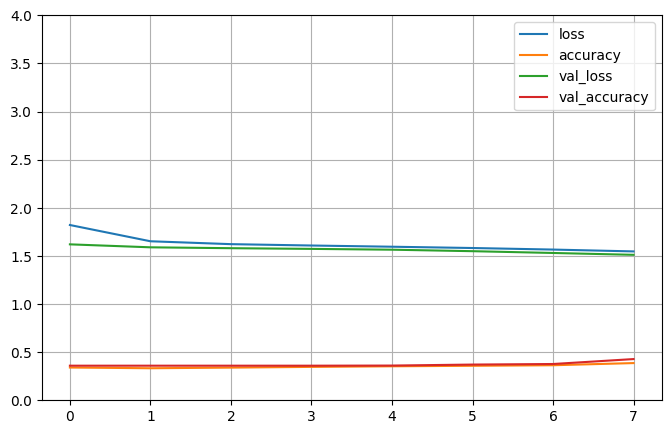

In [ ]:
pd.DataFrame(history_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.show()

## ResNet
For ResNet architecture, I got it from the practical notebook chapter 14 - Deep Computer Vision using CNN

In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
Resnet = keras.models.Sequential()
Resnet.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[112, 112, 3]))
Resnet.add(keras.layers.BatchNormalization())
Resnet.add(keras.layers.Activation("relu"))
Resnet.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    Resnet.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
Resnet.add(keras.layers.GlobalAvgPool2D())
Resnet.add(keras.layers.Flatten())
Resnet.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
Resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        9408      
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 28, 28, 64)       74240     
 )                                                               
                                                        

In [ ]:
Resnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_resnet = Resnet.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 304s 174ms/step - loss: 1.2502 - accuracy: 0.5693 - val_loss: 2.1956 - val_accuracy: 0.3406
Epoch 2/8
1563/1563 [==============================] - 269s 172ms/step - loss: 1.0654 - accuracy: 0.6321 - val_loss: 1.8139 - val_accuracy: 0.4338
Epoch 3/8
1563/1563 [==============================] - 344s 220ms/step - loss: 0.9637 - accuracy: 0.6649 - val_loss: 1.4806 - val_accuracy: 0.5283
Epoch 4/8
1563/1563 [==============================] - 268s 172ms/step - loss: 0.8809 - accuracy: 0.6902 - val_loss: 1.3355 - val_accuracy: 0.5473
Epoch 5/8
1563/1563 [==============================] - 329s 211ms/step - loss: 0.8051 - accuracy: 0.7147 - val_loss: 1.1156 - val_accuracy: 0.6196
Epoch 6/8
1563/1563 [==============================] - 270s 173ms/step - loss: 0.7234 - accuracy: 0.7423 - val_loss: 1.2668 - val_accuracy: 0.5774
Epoch 7/8
1563/1563 [==============================] - 268s 171ms/step - loss: 0.6287 - accuracy: 0.7742 - val_loss: 1.7001 - va

In [ ]:
pd.DataFrame(history_resnet.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-4]
plt.show()

## MobileNet V2
For MobileNetV2 Model, I got it from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

In [10]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(112, 112, 3),
                                               include_top=False,
                                               weights='imagenet')
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 1280)


In [ ]:
#Freeze the convolutional base
base_model.trainable = False

In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(8)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
mobilnet_model = tf.keras.Model(inputs, outputs)

(64, 1280)
(64, 8)


In [ ]:
base_learning_rate = 0.0001
mobilnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 8
history_mobilenet = mobilnet_model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/8
1563/1563 [==============================] - 196s 107ms/step - loss: 1.2992 - accuracy: 0.5693 - val_loss: 0.9806 - val_accuracy: 0.6612
Epoch 2/8
1563/1563 [==============================] - 199s 127ms/step - loss: 0.9953 - accuracy: 0.6577 - val_loss: 0.9059 - val_accuracy: 0.6848
Epoch 3/8
1563/1563 [==============================] - 199s 127ms/step - loss: 0.9296 - accuracy: 0.6762 - val_loss: 0.8752 - val_accuracy: 0.6946
Epoch 4/8
1563/1563 [==============================] - 193s 123ms/step - loss: 0.8969 - accuracy: 0.6864 - val_loss: 0.8580 - val_accuracy: 0.6997
Epoch 5/8
1563/1563 [==============================] - 195s 125ms/step - loss: 0.8753 - accuracy: 0.6920 - val_loss: 0.8474 - val_accuracy: 0.7022
Epoch 6/8
1563/1563 [==============================] - 195s 125ms/step - loss: 0.8644 - accuracy: 0.6961 - val_loss: 0.8400 - val_accuracy: 0.7048
Epoch 7/8
1563/1563 [==============================] - 196s 126ms/step - loss: 0.8539 - accuracy: 0.7000 - val_loss: 0

## MobileNet V2 Model 2

In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = Dense(8, activation="softmax")(x)
mobilenet_model_2 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001
mobilenet_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_mobile_2 = mobilenet_model_2.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 205s 127ms/step - loss: 1.2001 - accuracy: 0.5977 - val_loss: 0.9234 - val_accuracy: 0.6798
Epoch 2/10
1563/1563 [==============================] - 239s 153ms/step - loss: 0.9647 - accuracy: 0.6719 - val_loss: 0.8588 - val_accuracy: 0.6984
Epoch 3/10
1563/1563 [==============================] - 207s 132ms/step - loss: 0.9021 - accuracy: 0.6910 - val_loss: 0.8281 - val_accuracy: 0.7075
Epoch 4/10
1563/1563 [==============================] - 201s 129ms/step - loss: 0.8611 - accuracy: 0.7007 - val_loss: 0.8096 - val_accuracy: 0.7135
Epoch 5/10
1563/1563 [==============================] - 201s 129ms/step - loss: 0.8298 - accuracy: 0.7109 - val_loss: 0.7977 - val_accuracy: 0.7176
Epoch 6/10
1563/1563 [==============================] - 170s 109ms/step - loss: 0.8079 - accuracy: 0.7185 - val_loss: 0.7881 - val_accuracy: 0.7214
Epoch 7/10
1563/1563 [==============================] - 201s 128ms/step - loss: 0.7878 - accuracy: 0.7260 - val_loss: 0.780

## Fine Tuning

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = Dense(8, activation="softmax")(x)
fine_tune_1 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_fine_tune_1 = fine_tune_1.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 322s 195ms/step - loss: 0.9618 - accuracy: 0.6844 - val_loss: 0.7443 - val_accuracy: 0.7446
Epoch 2/10
1563/1563 [==============================] - 239s 153ms/step - loss: 0.7307 - accuracy: 0.7542 - val_loss: 0.6487 - val_accuracy: 0.7706
Epoch 3/10
1563/1563 [==============================] - 236s 151ms/step - loss: 0.6502 - accuracy: 0.7788 - val_loss: 0.6590 - val_accuracy: 0.7761
Epoch 4/10
1563/1563 [==============================] - 204s 130ms/step - loss: 0.5892 - accuracy: 0.7987 - val_loss: 0.6461 - val_accuracy: 0.7814
Epoch 5/10
1563/1563 [==============================] - 169s 108ms/step - loss: 0.5414 - accuracy: 0.8146 - val_loss: 0.6431 - val_accuracy: 0.7814
Epoch 6/10
1563/1563 [==============================] - 203s 130ms/step - loss: 0.4949 - accuracy: 0.8294 - val_loss: 0.6584 - val_accuracy: 0.7866
Epoch 7/10
1563/1563 [==============================] - 202s 130ms/step - loss: 0.4550 - accuracy: 0.8429 - val_loss: 0.693

In [ ]:
prediction_finetune_1=fine_tune_1.predict(test_ds)
prediction= np.argmax(prediction_finetune_1,axis=1)

782/782 [==============================] - 100s 125ms/step


In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:

test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = prediction
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_finetune_1.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Private Test: Coarse

In [ ]:
batch_size = 64
img_size = 112
fine_grain = False
num_classes = 50 if fine_grain else 8

root1 = Path('/content/privtest_coarse')
root1

PosixPath('/content/privtest_coarse')

In [ ]:
def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root1 / f"privtest_coarse.csv")
  file_paths = df.filename.map(lambda fn: str(root1 / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

In [ ]:
privtest_coarse_ds = create_dataset_tf('privtest', fine_grained=fine_grain, batch_size=batch_size)

In [ ]:
prediction_finetune_1=fine_tune_1.predict(privtest_coarse_ds)
prediction_private_coarse= np.argmax(prediction_finetune_1,axis=1)

24/24 [==============================] - 3s 105ms/step


In [ ]:
N = 1500     # num elements in test.csv
prediction = np.tile(prediction_private_coarse, (N//len(prediction_private_coarse) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root1 / f"privtest_coarse.csv")
test_csv.loc[:,"coarse"] = prediction
#test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_finetune_coarse_1.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Fine Tuning model 2

In this fine tuning model 2. I drop the fine tune layer to 50, where it starts the fine tuning after 50 layers. 
I also add batch normalization and regularizers l2. The purpose is trying to see whether increase the validation accuracy or not.

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = Dense(8, activation="softmax")(x)
fine_tune_2 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_fine_tune_2 = fine_tune_2.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 274s 158ms/step - loss: 2.1269 - accuracy: 0.6451 - val_loss: 1.5448 - val_accuracy: 0.6996
Epoch 2/10
1563/1563 [==============================] - 250s 160ms/step - loss: 1.2477 - accuracy: 0.7436 - val_loss: 1.1978 - val_accuracy: 0.7318
Epoch 3/10
1563/1563 [==============================] - 251s 161ms/step - loss: 0.8945 - accuracy: 0.7760 - val_loss: 1.1373 - val_accuracy: 0.6970
Epoch 4/10
1563/1563 [==============================] - 313s 200ms/step - loss: 0.6996 - accuracy: 0.8023 - val_loss: 0.8697 - val_accuracy: 0.7417
Epoch 5/10
1563/1563 [==============================] - 256s 164ms/step - loss: 0.5830 - accuracy: 0.8237 - val_loss: 1.1219 - val_accuracy: 0.6681
Epoch 6/10
1563/1563 [==============================] - 256s 164ms/step - loss: 0.4921 - accuracy: 0.8461 - val_loss: 0.8136 - val_accuracy: 0.7540
Epoch 7/10
1563/1563 [==============================] - 314s 201ms/step - loss: 0.4254 - accuracy: 0.8643 - val_loss: 0.906

## Fine Tune Model 3

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='elu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = Dense(128, activation='selu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = Dense(8, activation="softmax")(x)
fine_tune_3 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_fine_tune_3 = fine_tune_3.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 176s 109ms/step - loss: 2.6091 - accuracy: 0.5498 - val_loss: 1.8297 - val_accuracy: 0.6861
Epoch 2/10
1563/1563 [==============================] - 169s 108ms/step - loss: 1.8148 - accuracy: 0.6417 - val_loss: 1.4214 - val_accuracy: 0.6987
Epoch 3/10
1563/1563 [==============================] - 195s 125ms/step - loss: 1.4263 - accuracy: 0.6666 - val_loss: 1.1683 - val_accuracy: 0.7048
Epoch 4/10
1563/1563 [==============================] - 165s 105ms/step - loss: 1.1883 - accuracy: 0.6808 - val_loss: 1.0151 - val_accuracy: 0.7096
Epoch 5/10
1563/1563 [==============================] - 166s 106ms/step - loss: 1.0428 - accuracy: 0.6930 - val_loss: 0.9252 - val_accuracy: 0.7144
Epoch 6/10
1563/1563 [==============================] - 196s 125ms/step - loss: 0.9538 - accuracy: 0.7006 - val_loss: 0.8723 - val_accuracy: 0.7169
Epoch 7/10
1563/1563 [==============================] - 191s 122ms/step - loss: 0.8968 - accuracy: 0.7094 - val_loss: 0.838

In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:

test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = prediction
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_finetune_1.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Fine Tune Model 4: using Best Model

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = Dense(128, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = Dense(8, activation="softmax")(x)
fine_tune_4 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_fine_tune_4 = fine_tune_4.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 336s 204ms/step - loss: 2.0791 - accuracy: 0.6500 - val_loss: 1.5069 - val_accuracy: 0.7146
Epoch 2/10
1563/1563 [==============================] - 241s 154ms/step - loss: 1.2249 - accuracy: 0.7345 - val_loss: 1.0383 - val_accuracy: 0.7294
Epoch 3/10
1563/1563 [==============================] - 302s 193ms/step - loss: 0.9009 - accuracy: 0.7647 - val_loss: 0.7999 - val_accuracy: 0.7739
Epoch 4/10
1563/1563 [==============================] - 239s 153ms/step - loss: 0.7365 - accuracy: 0.7868 - val_loss: 0.8332 - val_accuracy: 0.7518
Epoch 5/10
1563/1563 [==============================] - 241s 154ms/step - loss: 0.6293 - accuracy: 0.8070 - val_loss: 0.8068 - val_accuracy: 0.7533
Epoch 6/10
1563/1563 [==============================] - 246s 157ms/step - loss: 0.5487 - accuracy: 0.8253 - val_loss: 0.7284 - val_accuracy: 0.7770
Epoch 7/10
1563/1563 [==============================] - 224s 143ms/step - loss: 0.4837 - accuracy: 0.8435 - val_loss: 0.997

## Fine Tune Model 5

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='elu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = Dense(128, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = Dense(8, activation="softmax")(x)
fine_tune_5 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_fine_tune_5 = fine_tune_5.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 243s 151ms/step - loss: 2.5920 - accuracy: 0.5493 - val_loss: 1.8173 - val_accuracy: 0.6847
Epoch 2/10
1563/1563 [==============================] - 229s 146ms/step - loss: 1.7869 - accuracy: 0.6434 - val_loss: 1.3966 - val_accuracy: 0.6979
Epoch 3/10
1563/1563 [==============================] - 228s 146ms/step - loss: 1.3959 - accuracy: 0.6687 - val_loss: 1.1448 - val_accuracy: 0.7058
Epoch 4/10
1563/1563 [==============================] - 252s 161ms/step - loss: 1.1640 - accuracy: 0.6828 - val_loss: 0.9973 - val_accuracy: 0.7106
Epoch 5/10
1563/1563 [==============================] - 198s 127ms/step - loss: 1.0273 - accuracy: 0.6926 - val_loss: 0.9136 - val_accuracy: 0.7143
Epoch 6/10
1563/1563 [==============================] - 200s 128ms/step - loss: 0.9460 - accuracy: 0.7013 - val_loss: 0.8647 - val_accuracy: 0.7177
Epoch 7/10
1563/1563 [==============================] - 196s 125ms/step - loss: 0.8926 - accuracy: 0.7077 - val_loss: 0.833

Prediction Using model 4

In [ ]:
prediction_4=CNNmodel_4.predict(test_ds)
prediction= np.argmax(prediction_4,axis=1)

782/782 [==============================] - 89s 113ms/step


In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:

test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = prediction
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_4.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

mobile net prediction model 2

In [ ]:
prediction_mobilenet_2= mobilenet_model_2.predict(test_ds)
prediction= np.argmax(prediction_mobilenet_2,axis=1)

782/782 [==============================] - 96s 121ms/step


In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = prediction
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_5_mobilenetv2.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = prediction
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_3.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

In [ ]:
prediction_2=CNNmodel_1.predict(test_ds)
prediction= np.argmax(prediction_1,axis=1) 

782/782 [==============================] - 83s 106ms/step


In [ ]:
prediction_3=CNNmodel_2.predict(test_ds)
prediction= np.argmax(prediction_3,axis=1)

782/782 [==============================] - 93s 118ms/step


In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = prediction
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_2.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Fine Tune Model 4: Best Model with 15 epoch

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = Dense(128, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = Dense(8, activation="softmax")(x)
fine_tune_4_v1 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_4_v1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 15
history_fine_tune_4_v1 = fine_tune_4_v1.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
1563/1563 [==============================] - 260s 155ms/step - loss: 2.1537 - accuracy: 0.6463 - val_loss: 1.6617 - val_accuracy: 0.6876
Epoch 2/15
1563/1563 [==============================] - 240s 154ms/step - loss: 1.3035 - accuracy: 0.7313 - val_loss: 1.0821 - val_accuracy: 0.7314
Epoch 3/15
1563/1563 [==============================] - 202s 129ms/step - loss: 0.9478 - accuracy: 0.7610 - val_loss: 1.0152 - val_accuracy: 0.6801
Epoch 4/15
1563/1563 [==============================] - 168s 107ms/step - loss: 0.7561 - accuracy: 0.7844 - val_loss: 0.8721 - val_accuracy: 0.7203
Epoch 5/15
1563/1563 [==============================] - 202s 129ms/step - loss: 0.6406 - accuracy: 0.8039 - val_loss: 0.7398 - val_accuracy: 0.7689
Epoch 6/15
1563/1563 [==============================] - 202s 129ms/step - loss: 0.5553 - accuracy: 0.8229 - val_loss: 0.7481 - val_accuracy: 0.7617
Epoch 7/15
1563/1563 [==============================] - 201s 129ms/step - loss: 0.4875 - accuracy: 0.8420 - val_

# Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

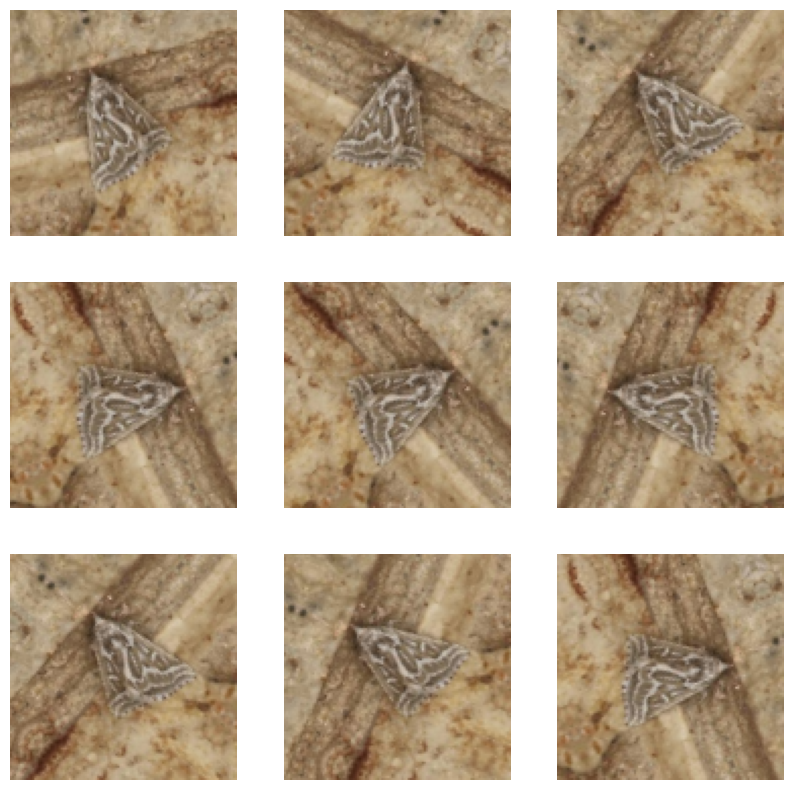

In [13]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

# Applying data augmentation to the best model (Fine Tuning model)

In [14]:
#un freeze the model
base_model.trainable = True

In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [16]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = Dense(8, activation="softmax")(x)
fine_tune_aug = tf.keras.Model(inputs, outputs)

(64, 1280)


In [17]:
base_learning_rate = 0.0001

fine_tune_aug.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [18]:
initial_epochs = 10
history_fine_tune_aug = fine_tune_aug.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 349s 210ms/step - loss: 0.9653 - accuracy: 0.6837 - val_loss: 0.7269 - val_accuracy: 0.7503
Epoch 2/10
1563/1563 [==============================] - 298s 190ms/step - loss: 0.7325 - accuracy: 0.7532 - val_loss: 0.6540 - val_accuracy: 0.7712
Epoch 3/10
1563/1563 [==============================] - 337s 216ms/step - loss: 0.6461 - accuracy: 0.7789 - val_loss: 0.6644 - val_accuracy: 0.7797
Epoch 4/10
1563/1563 [==============================] - 254s 163ms/step - loss: 0.5872 - accuracy: 0.7984 - val_loss: 0.6492 - val_accuracy: 0.7773
Epoch 5/10
1563/1563 [==============================] - 239s 153ms/step - loss: 0.5387 - accuracy: 0.8137 - val_loss: 0.6310 - val_accuracy: 0.7890
Epoch 6/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.4935 - accuracy: 0.8306 - val_loss: 0.6470 - val_accuracy: 0.7871
Epoch 7/10
1563/1563 [==============================] - 204s 131ms/step - loss: 0.4505 - accuracy: 0.8441 - val_loss: 0.692

# 2. Deep Learning : Selected Fine Data

The best selected model is Fine Model 1 which gives 39% score



In [19]:
batch_size = 64
img_size = 112
fine_grain = True
num_classes = 50 if fine_grain else 8

root = Path('/content/public')

In [20]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y




In [21]:
import tensorflow as tf
from tensorflow import keras

In [22]:
fine_grained = True

In [23]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=batch_size)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=batch_size)

## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

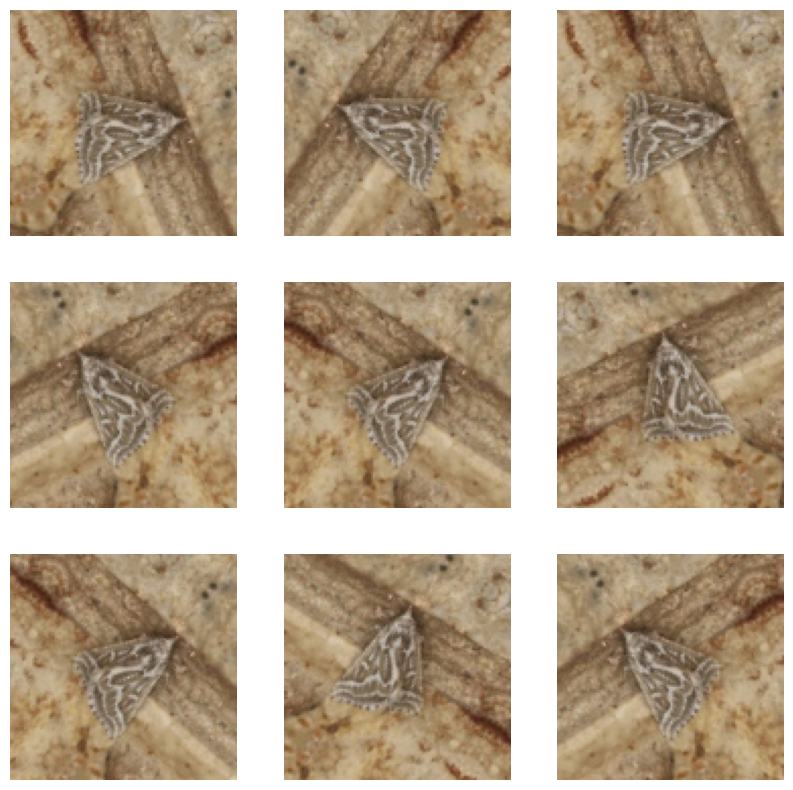

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

## Fine Model 1

In [ ]:
CNNmodel_fine_1 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(50, activation='softmax')
    ])

In [ ]:
CNNmodel_fine_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
CNNmodel_fine_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_fine_1 = CNNmodel_fine_1.fit(train_ds, epochs=8, 
                    validation_data=(val_ds))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 240s 146ms/step - loss: 3.5168 - accuracy: 0.0835 - val_loss: 3.2479 - val_accuracy: 0.1337
Epoch 2/8
1563/1563 [==============================] - 222s 142ms/step - loss: 3.1735 - accuracy: 0.1450 - val_loss: 3.0791 - val_accuracy: 0.1661
Epoch 3/8
1563/1563 [==============================] - 222s 142ms/step - loss: 2.9618 - accuracy: 0.1866 - val_loss: 3.1131 - val_accuracy: 0.1666
Epoch 4/8
1563/1563 [==============================] - 193s 124ms/step - loss: 2.7471 - accuracy: 0.2308 - val_loss: 3.2331 - val_accuracy: 0.1626
Epoch 5/8
1563/1563 [==============================] - 216s 138ms/step - loss: 2.5265 - accuracy: 0.2802 - val_loss: 3.4316 - val_accuracy: 0.1590
Epoch 6/8
1563/1563 [==============================] - 194s 124ms/step - loss: 2.3195 - accuracy: 0.3273 - val_loss: 3.7431 - val_accuracy: 0.1498
Epoch 7/8
1563/1563 [==============================] - 190s 122ms/step - loss: 2.1385 - accuracy: 0.3672 - val_loss: 4.0568 - va

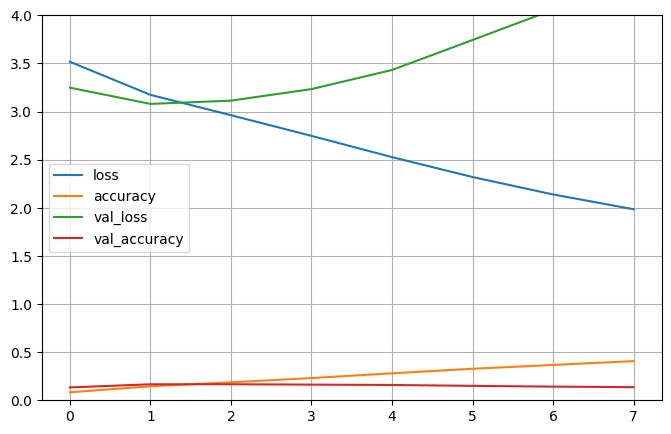

In [ ]:
pd.DataFrame(history_fine_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.show()

In [ ]:
prediction_fine_1= CNNmodel_fine_1.predict(test_ds)
prediction= np.argmax(prediction_fine_1,axis=1)

782/782 [==============================] - 83s 106ms/step


In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = prediction
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_fine_data.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Fine data using fine tuning

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(112, 112, 3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 1280)


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = Dense(50, activation="softmax")(x)
fine_tune_fine_1 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_fine_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_fine_tune_fine_1 = fine_tune_fine_1.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 220s 132ms/step - loss: 3.4694 - accuracy: 0.0974 - val_loss: 2.7836 - val_accuracy: 0.2440
Epoch 2/10
1563/1563 [==============================] - 219s 140ms/step - loss: 2.8223 - accuracy: 0.2402 - val_loss: 2.5040 - val_accuracy: 0.3177
Epoch 3/10
1563/1563 [==============================] - 203s 130ms/step - loss: 2.5679 - accuracy: 0.3039 - val_loss: 2.3958 - val_accuracy: 0.3340
Epoch 4/10
1563/1563 [==============================] - 169s 108ms/step - loss: 2.4049 - accuracy: 0.3428 - val_loss: 2.3123 - val_accuracy: 0.3602
Epoch 5/10
1563/1563 [==============================] - 203s 130ms/step - loss: 2.2760 - accuracy: 0.3750 - val_loss: 2.2908 - val_accuracy: 0.3663
Epoch 6/10
1563/1563 [==============================] - 171s 110ms/step - loss: 2.1677 - accuracy: 0.4019 - val_loss: 2.2749 - val_accuracy: 0.3743
Epoch 7/10
1563/1563 [==============================] - 203s 130ms/step - loss: 2.0704 - accuracy: 0.4266 - val_loss: 2.298

In [ ]:
prediction_fine_finetune_1= fine_tune_fine_1.predict(test_ds)
prediction= np.argmax(prediction_fine_finetune_1,axis=1)

782/782 [==============================] - 71s 90ms/step


In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = prediction
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_fine_data_finetuning_1.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Private Test: Fine

In [ ]:
batch_size = 64
img_size = 112
fine_grain = True
num_classes = 50 if fine_grain else 8

root2 = Path('/content/privtest_fine')

In [ ]:
def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root2 / f"privtest_fine.csv")
  file_paths = df.filename.map(lambda fn: str(root2 / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

In [ ]:
privtest_fine_ds = create_dataset_tf('privtest', fine_grained=fine_grain, batch_size=batch_size)
## just make sure your privatest_coarse.csv is on the root location defined above and the testimgae folder is also on this same locaation

In [ ]:
prediction_finetune_1=fine_tune_1.predict(privtest_fine_ds)
prediction_private_fine= np.argmax(prediction_finetune_1,axis=1)

24/24 [==============================] - 2s 81ms/step


In [ ]:
N = 1500     # num elements in test.csv
prediction = np.tile(prediction_private_fine, (N//len(prediction_private_fine) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root2 / f"privtest_fine.csv")
test_csv.loc[:,"fine"] = prediction
#test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_finetune_fine_privtest_1.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Fine data using fine tuning V1

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [25]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 1280)


In [26]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = Dense(50, activation="softmax")(x)
fine_tune_fine_1_v1 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [27]:
base_learning_rate = 0.0001

fine_tune_fine_1_v1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [28]:
initial_epochs = 10
history_fine_tune_fine_1_v1 = fine_tune_fine_1_v1.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 231s 143ms/step - loss: 3.0889 - accuracy: 0.1652 - val_loss: 2.7065 - val_accuracy: 0.2496
Epoch 2/10
1563/1563 [==============================] - 304s 195ms/step - loss: 2.6101 - accuracy: 0.2347 - val_loss: 2.6270 - val_accuracy: 0.2760
Epoch 3/10
1563/1563 [==============================] - 214s 137ms/step - loss: 2.4803 - accuracy: 0.2617 - val_loss: 2.5873 - val_accuracy: 0.2885
Epoch 4/10
1563/1563 [==============================] - 191s 122ms/step - loss: 2.3980 - accuracy: 0.2803 - val_loss: 2.5589 - val_accuracy: 0.3012
Epoch 5/10
1563/1563 [==============================] - 177s 113ms/step - loss: 2.3401 - accuracy: 0.2982 - val_loss: 2.5429 - val_accuracy: 0.3094
Epoch 6/10
1563/1563 [==============================] - 200s 128ms/step - loss: 2.2977 - accuracy: 0.3120 - val_loss: 2.5428 - val_accuracy: 0.3138
Epoch 7/10
1563/1563 [==============================] - 223s 143ms/step - loss: 2.2614 - accuracy: 0.3229 - val_loss: 2.521

In [ ]:
prediction_fine_finetune_1_v1= fine_tune_fine_1_v1.predict(test_ds)
prediction= np.argmax(prediction_fine_finetune_1_v1,axis=1)

782/782 [==============================] - 70s 88ms/step


In [ ]:
N = 50000     # num elements in test.csv
prediction = np.tile(prediction, (N//len(prediction) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = prediction
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_fine_data_finetuning_1_v1.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

In [ ]:
privtest_fine_ds = create_dataset_tf('privtest', fine_grained=fine_grain, batch_size=batch_size)


In [ ]:
prediction_finetune_1=fine_tune_1.predict(privtest_fine_ds)
prediction_private_fine= np.argmax(prediction_finetune_1,axis=1)

In [ ]:
N = 1500     # num elements in test.csv
prediction = np.tile(prediction_private_fine, (N//len(prediction_private_fine) + 1))[:N]  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root2 / f"privtest_fine.csv")
test_csv.loc[:,"fine"] = prediction
#test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/Comp8220/46775226-deep_finetune_fine_privtest_1.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index = False)

## Private Test: Fine

In [ ]:
batch_size = 64
img_size = 112
fine_grain = True
num_classes = 50 if fine_grain else 8

root2 = Path('/content/privtest_fine')

In [ ]:
def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root2 / f"privtest_fine.csv")
  file_paths = df.filename.map(lambda fn: str(root2 / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

## Fine data using fine tuning model 3

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='elu')(x) #elu activation
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = Dense(128, activation='selu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) #selu activation
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = Dense(50, activation="softmax")(x)
fine_tune_fine_2 = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_fine_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_fine_tune_fine_2 = fine_tune_fine_2.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 218s 130ms/step - loss: 4.3167 - accuracy: 0.1333 - val_loss: 3.7625 - val_accuracy: 0.1435
Epoch 2/10
1563/1563 [==============================] - 205s 131ms/step - loss: 3.4505 - accuracy: 0.1878 - val_loss: 3.3865 - val_accuracy: 0.1980
Epoch 3/10
1563/1563 [==============================] - 220s 141ms/step - loss: 3.0558 - accuracy: 0.2175 - val_loss: 3.1501 - val_accuracy: 0.1958
Epoch 4/10
1563/1563 [==============================] - 203s 130ms/step - loss: 2.8127 - accuracy: 0.2391 - val_loss: 3.0099 - val_accuracy: 0.2208
Epoch 5/10
1563/1563 [==============================] - 165s 106ms/step - loss: 2.6619 - accuracy: 0.2528 - val_loss: 2.8870 - val_accuracy: 0.2505
Epoch 6/10
1563/1563 [==============================] - 194s 124ms/step - loss: 2.5513 - accuracy: 0.2676 - val_loss: 2.8131 - val_accuracy: 0.2390
Epoch 7/10
1563/1563 [==============================] - 195s 125ms/step - loss: 2.4821 - accuracy: 0.2772 - val_loss: 2.888

## Fine data using Data Augmentation

In [ ]:
#un freeze the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# The model architecture
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)

x = Dense(128, activation='elu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = Dense(128, activation='selu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = Dense(50, activation="softmax")(x)
fine_tune_fine_augment = tf.keras.Model(inputs, outputs)

(64, 1280)


In [ ]:
base_learning_rate = 0.0001

fine_tune_fine_augment.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history_test_augment = fine_tune_fine_augment.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 196s 113ms/step - loss: 4.0235 - accuracy: 0.2056 - val_loss: 3.3911 - val_accuracy: 0.2938
Epoch 2/10
1563/1563 [==============================] - 207s 133ms/step - loss: 3.0332 - accuracy: 0.3114 - val_loss: 2.9702 - val_accuracy: 0.3284
Epoch 3/10
1563/1563 [==============================] - 203s 130ms/step - loss: 2.5878 - accuracy: 0.3636 - val_loss: 2.7976 - val_accuracy: 0.3475
Epoch 4/10
1563/1563 [==============================] - 169s 108ms/step - loss: 2.2801 - accuracy: 0.4047 - val_loss: 2.7829 - val_accuracy: 0.3604
Epoch 5/10
1563/1563 [==============================] - 204s 131ms/step - loss: 2.0660 - accuracy: 0.4386 - val_loss: 2.7169 - val_accuracy: 0.3633
Epoch 6/10
1563/1563 [==============================] - 205s 131ms/step - loss: 1.8959 - accuracy: 0.4696 - val_loss: 2.6003 - val_accuracy: 0.3688
Epoch 7/10
1563/1563 [==============================] - 169s 108ms/step - loss: 1.7607 - accuracy: 0.4979 - val_loss: 2.633

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning have better prediction accuracy, as I have 78% on the public dataset (coarse), while ML have 47%. In the deep learning I got 27th in kaggle leaderboard on public dataset with the score of 72%. Given the limited timeframe for private dataset, I got 25th place in kaggle leaderboard with the score of 77%.

For fine dataset, Deep learning model also perform better than ML. I got 40% and placed 21st in the kaggle leaderboard for public dataset while as for private dataset, I got 34% and got 25th position in kaggle leaderboard.

I'm trying to compare my result submission to the top submission from other people, where it got more than 90% for the coarse and as for the fine dataset is more than 70%. I think that they found the right combination for the regularization or train the data with more epoch with powerful GPU. 

As for the accuracy of the dataset between public and private dataset is because of the size. Private dataset have less images than the public dataset, resulting higher accuracy. For private fine dataset, there might be something that I have to add to increase the accuracy. 

For my kaggle submission, the result keep increasing because I kepe experimenting with different kind of settings. When training for deep learning model, the model faced overfitting problems. The way to mitigate overfitting is by experimenting with different kind of settings such as dropout regularization, L2& he_normal regularization, batch normalization and data augmentation. Comparing each model results with different architecture.

A limitation of GPU makes the epoch training limited to 8,10, and 15.


References:

* Géron, A., 2022. Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.

* Google Collab practical session
